In [9]:
import pandas as pd
import matplotlib.pyplot as plt

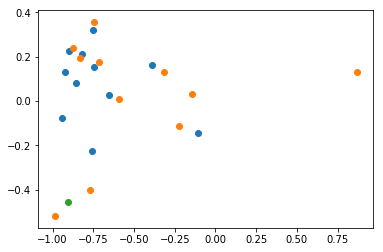

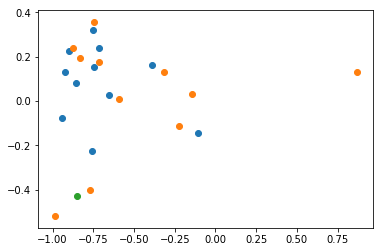

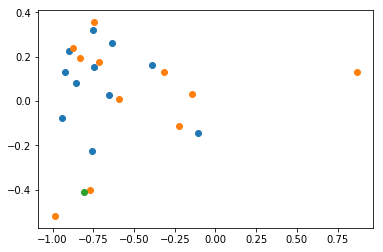

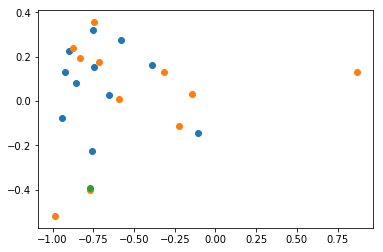

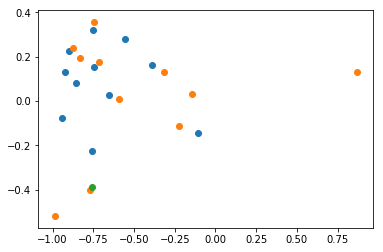

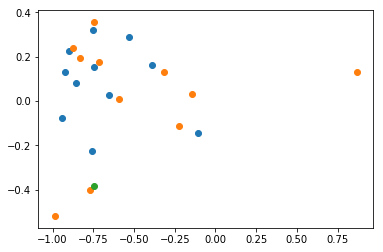

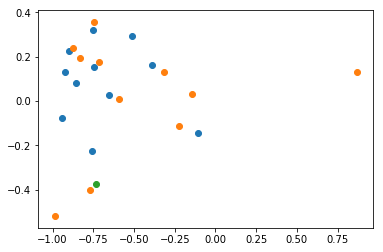

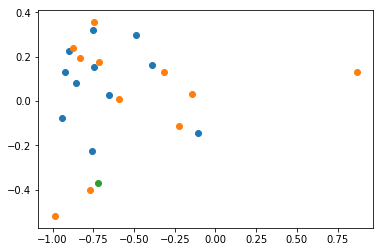

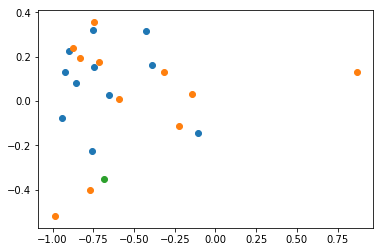

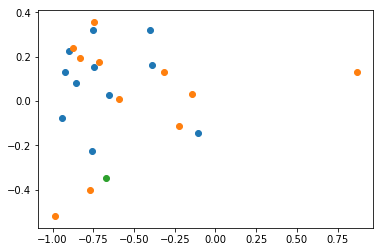

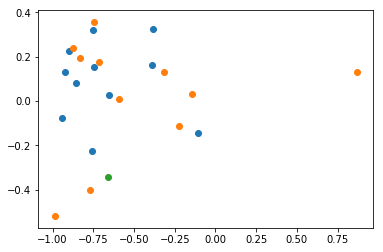

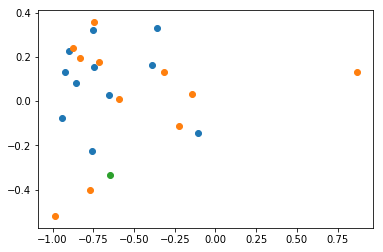

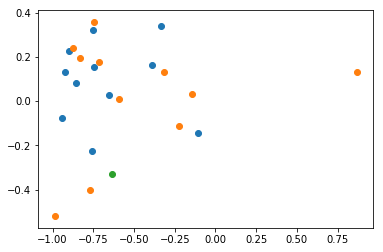

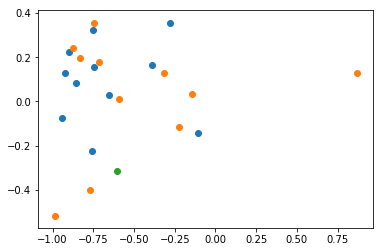

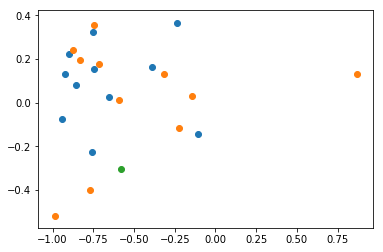

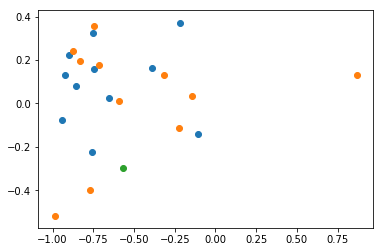

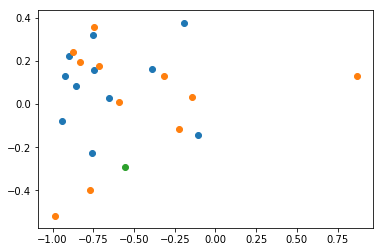

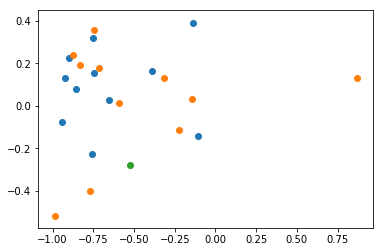

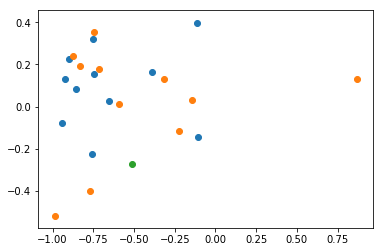

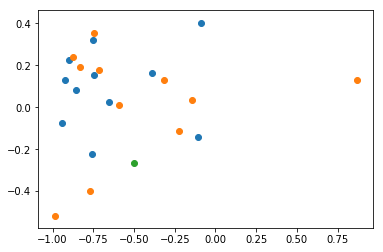

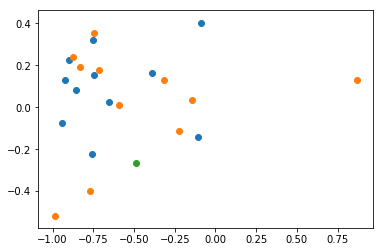

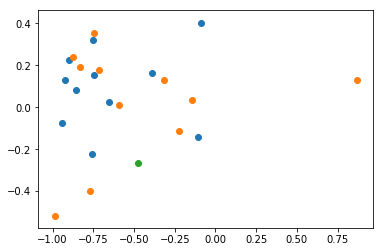

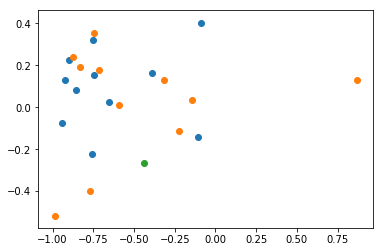

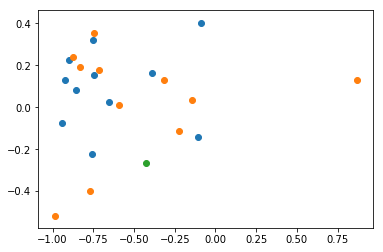

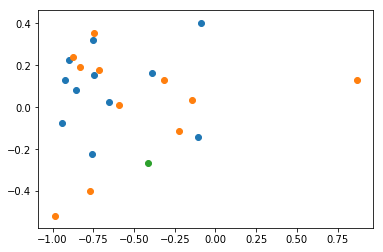

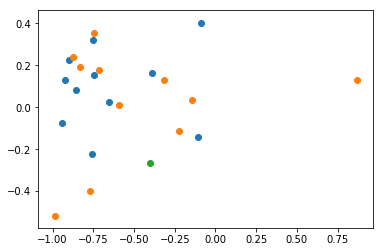

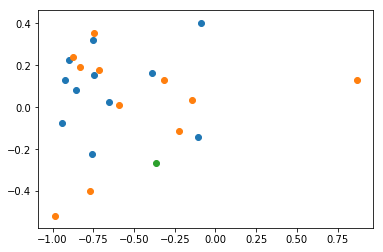

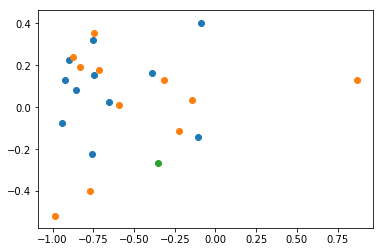

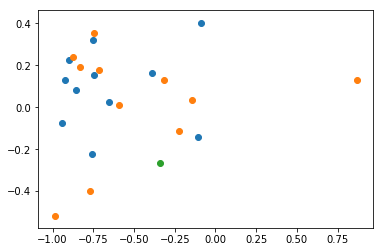

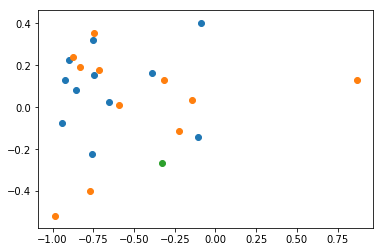

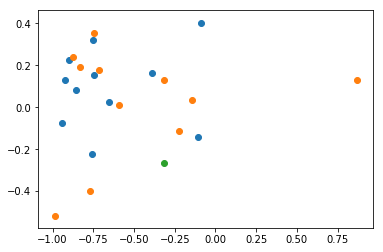

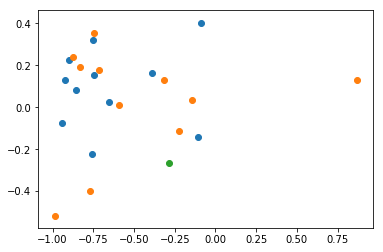

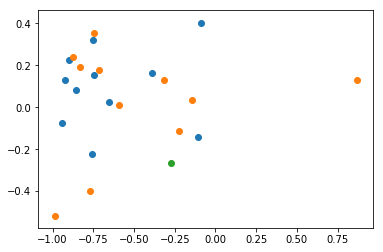

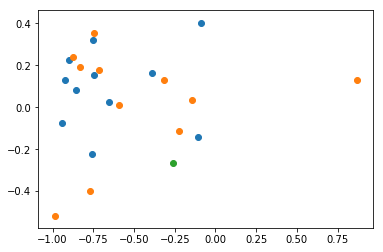

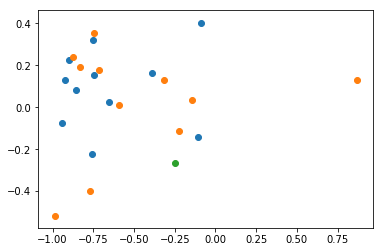

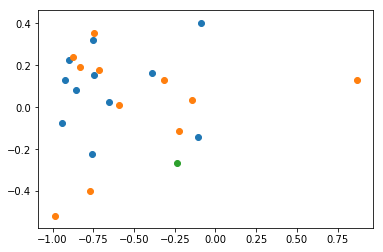

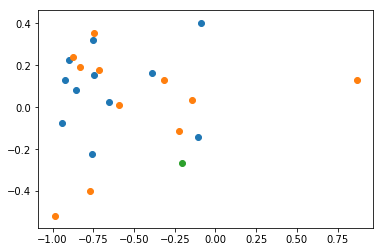

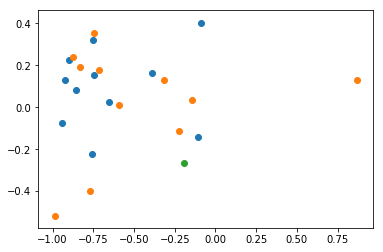

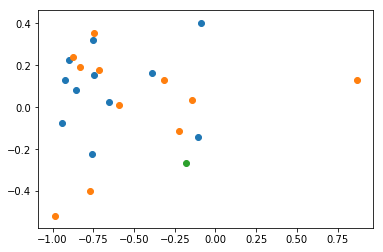

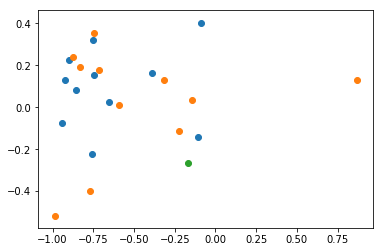

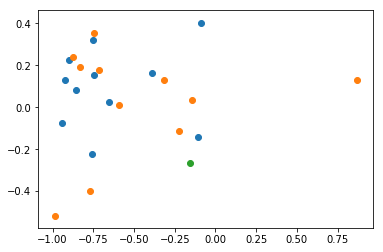

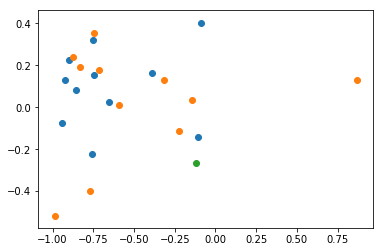

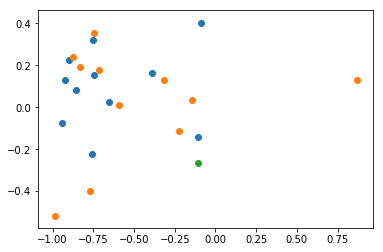

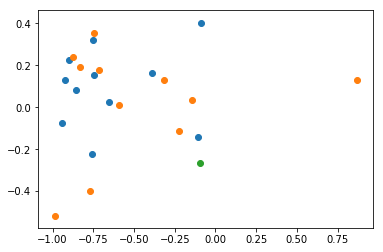

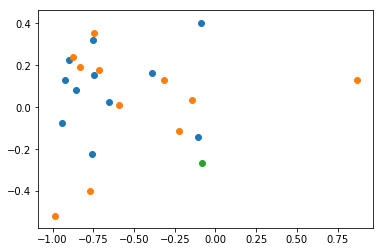

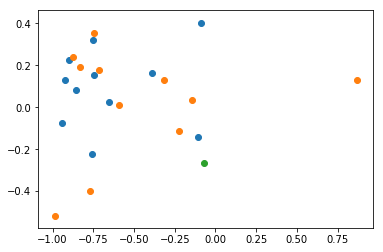

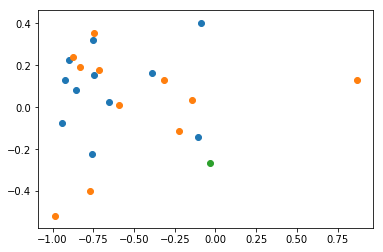

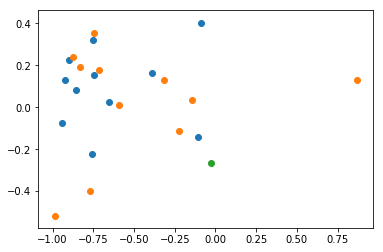

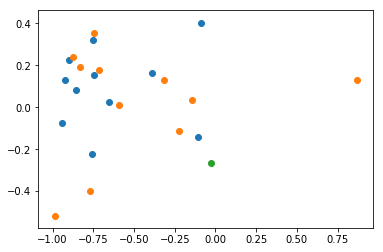

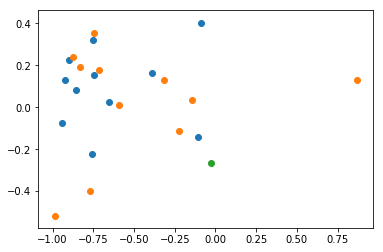

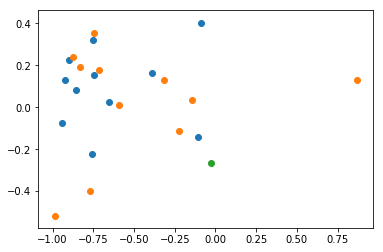

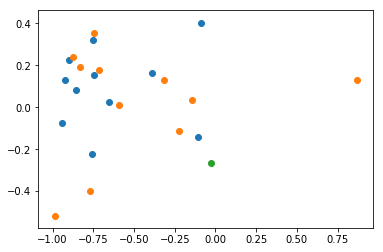

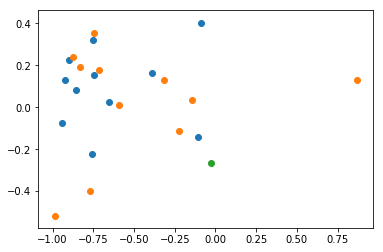

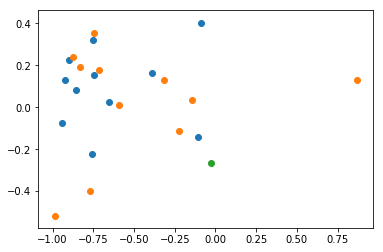

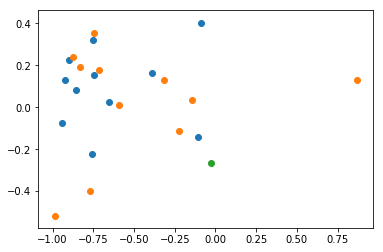

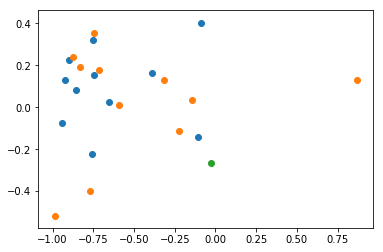

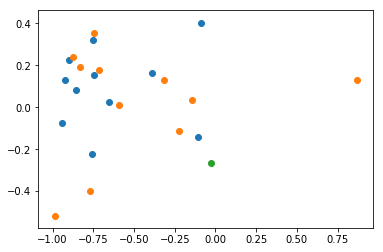

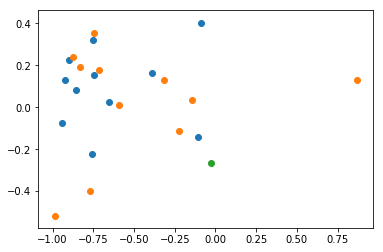

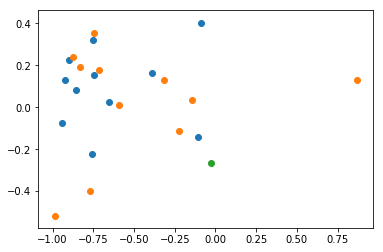

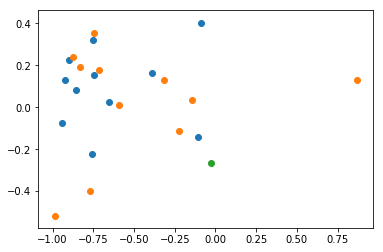

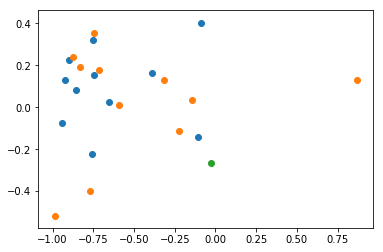

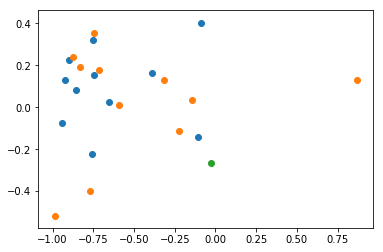

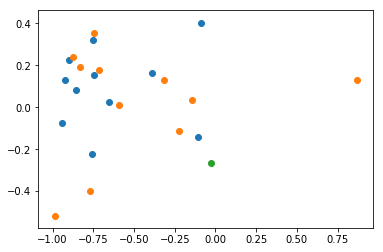

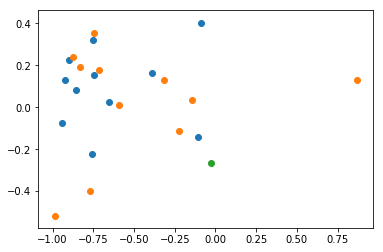

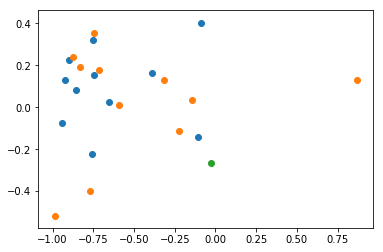

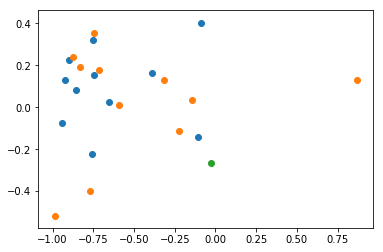

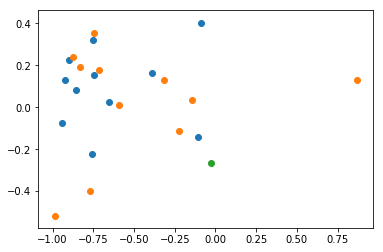

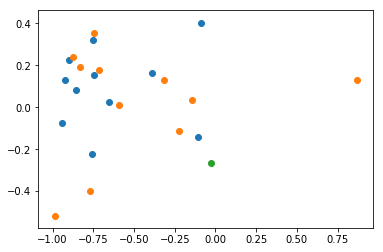

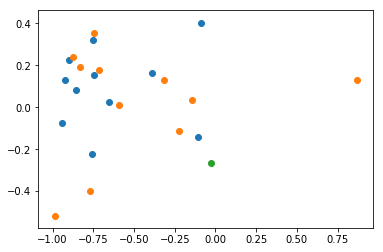

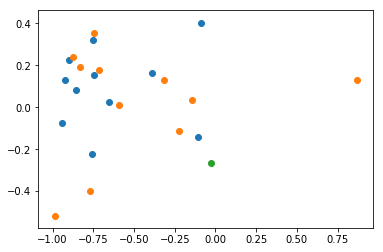

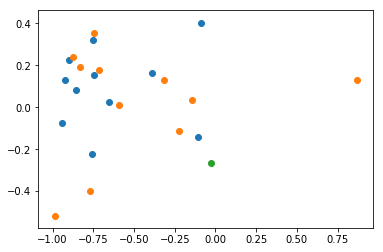

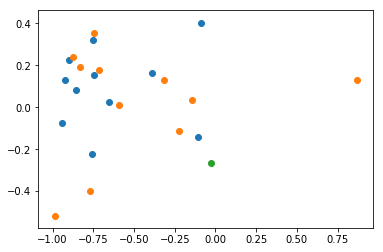

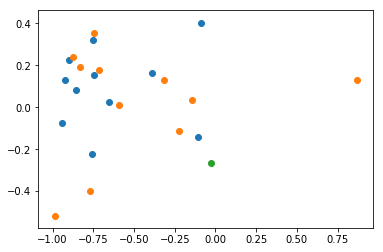

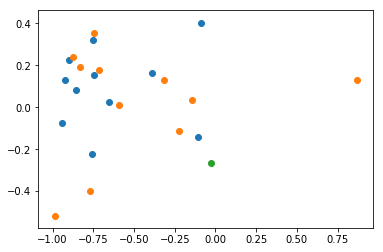

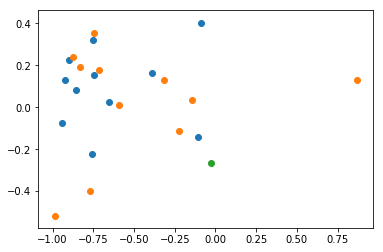

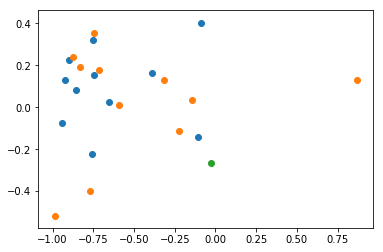

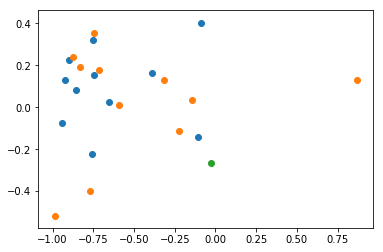

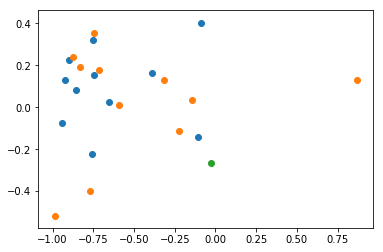

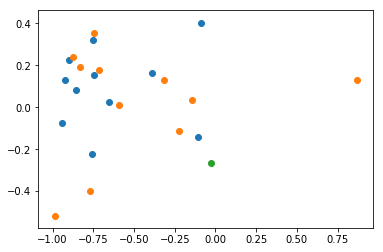

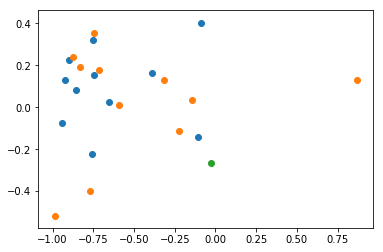

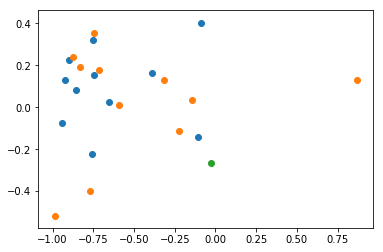

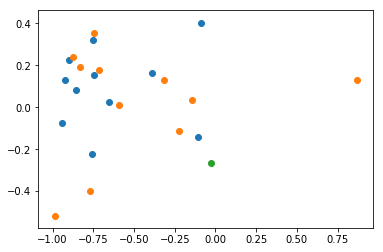

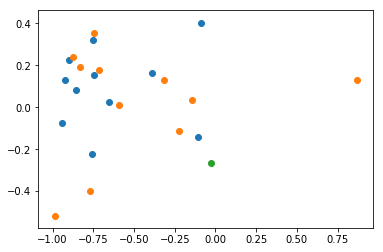

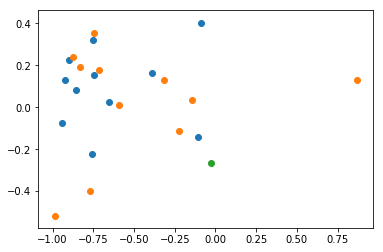

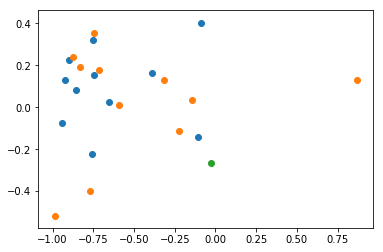

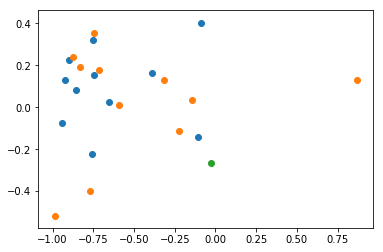

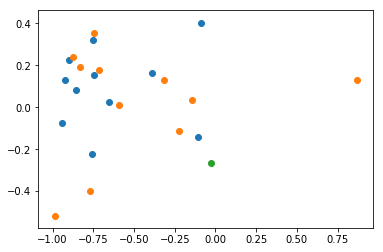

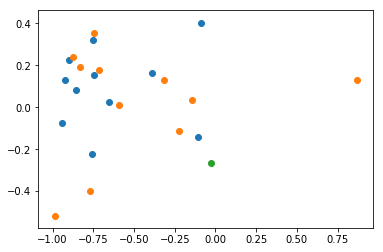

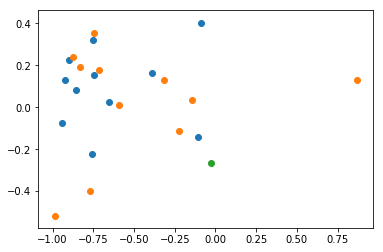

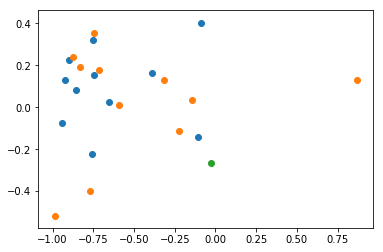

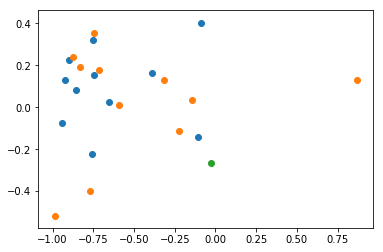

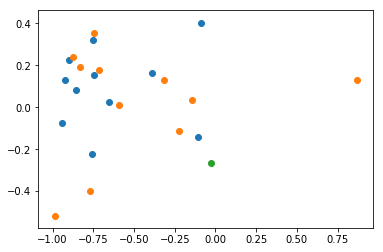

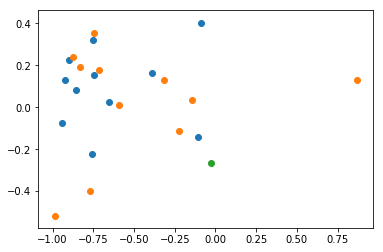

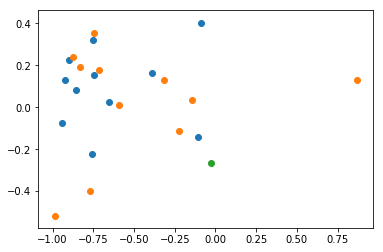

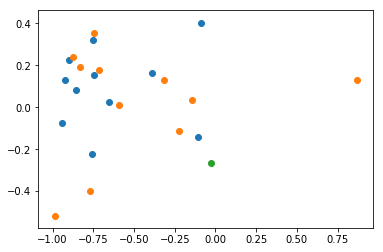

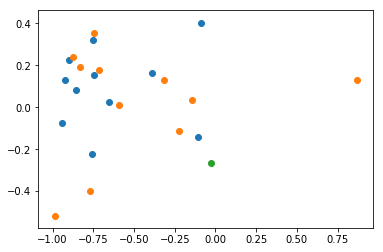

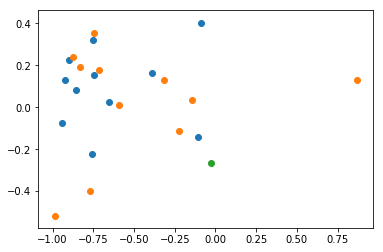

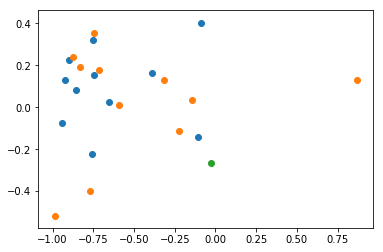

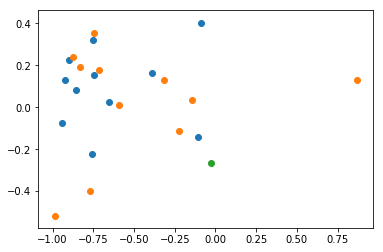

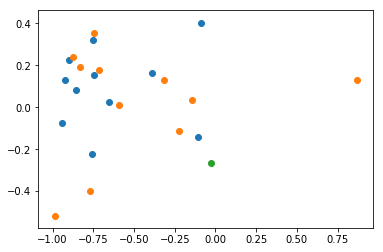

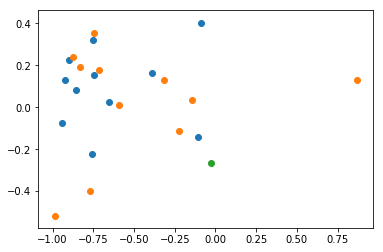

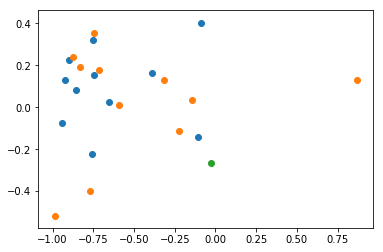

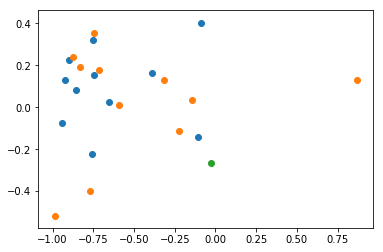

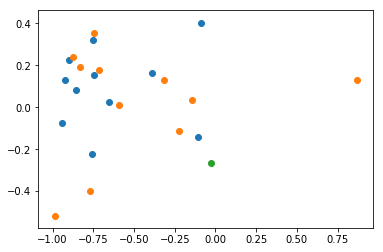

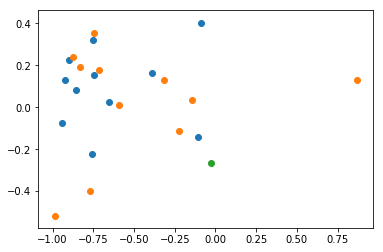

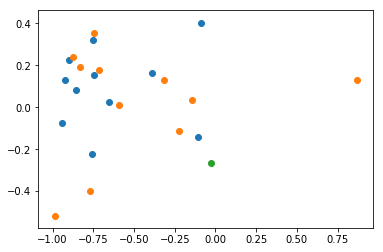

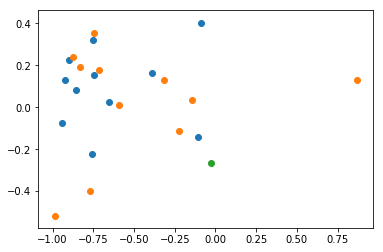

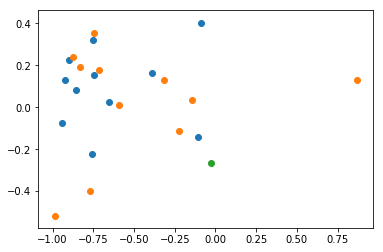

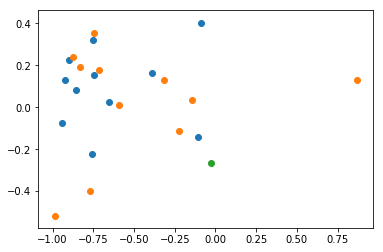

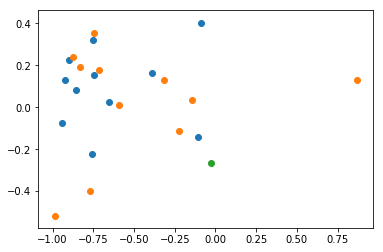

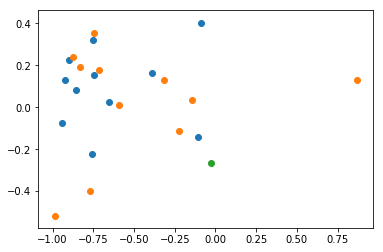

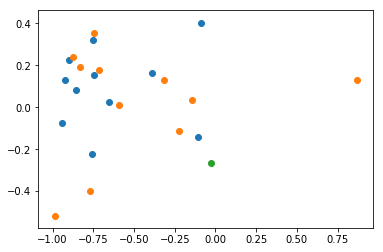

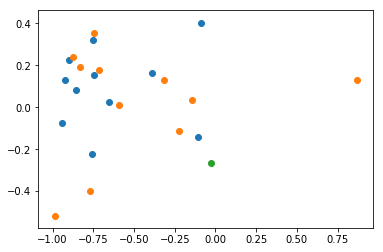

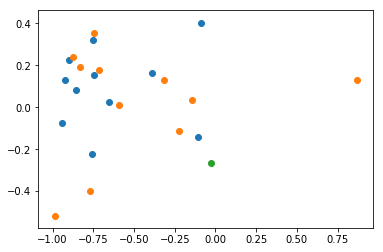

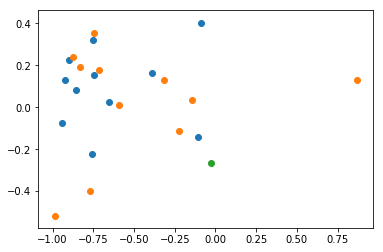

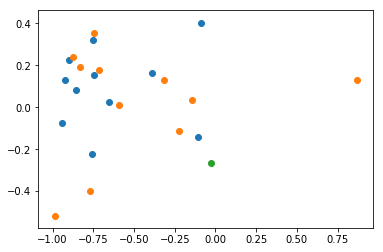

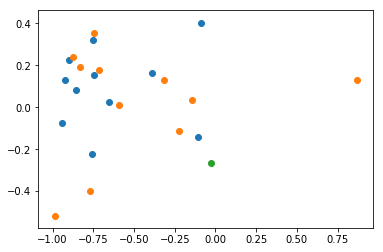

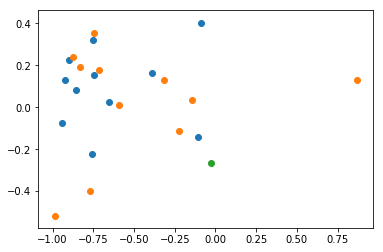

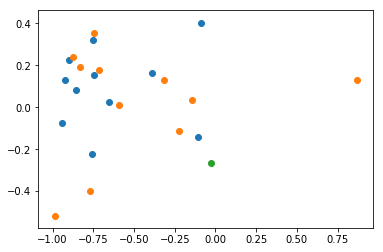

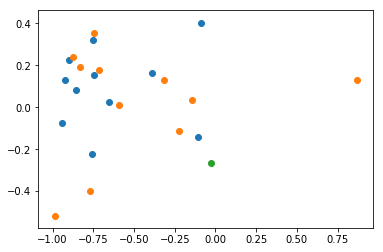

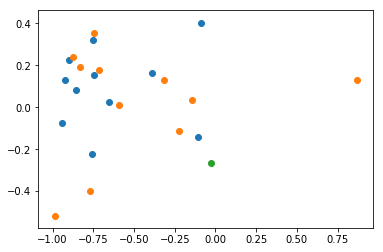

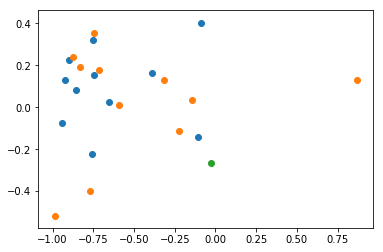

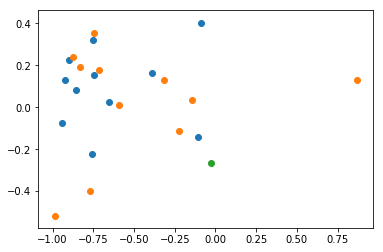

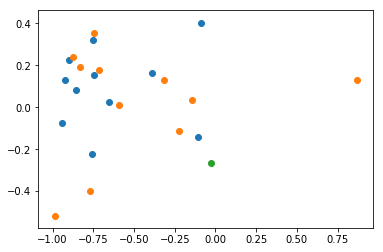

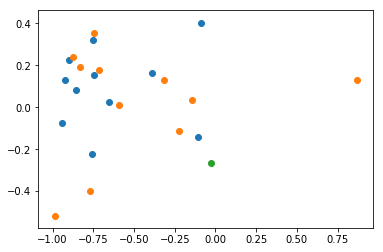

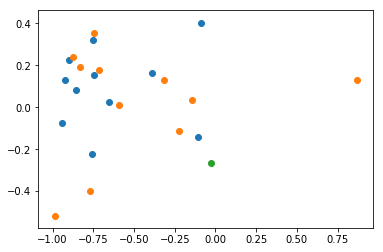

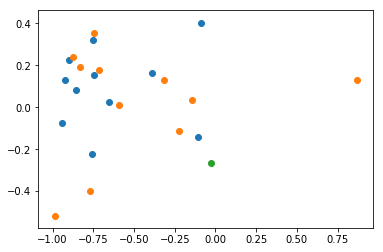

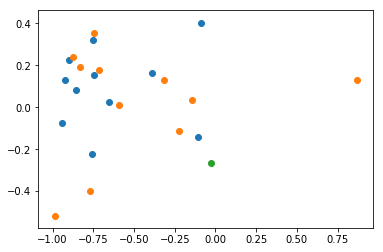

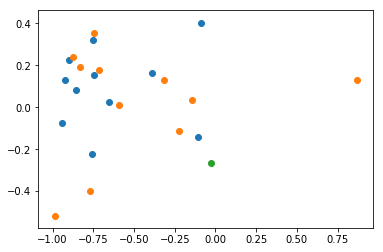

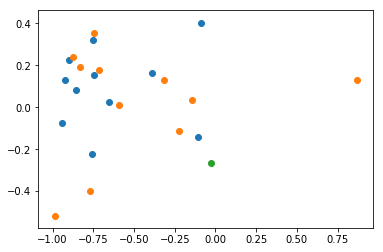

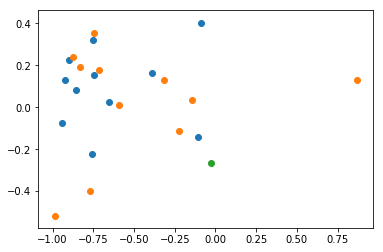

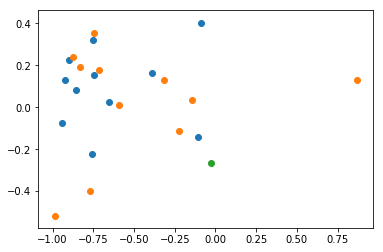

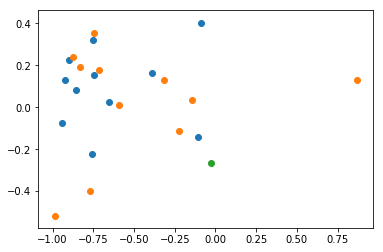

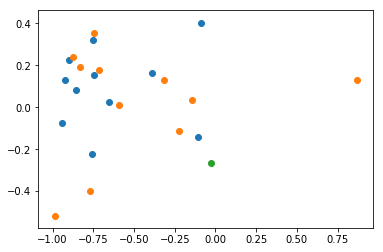

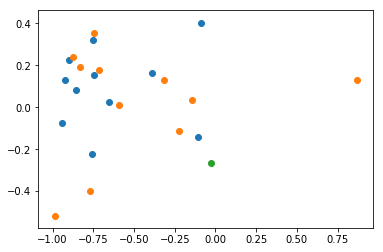

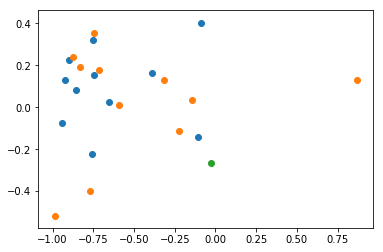

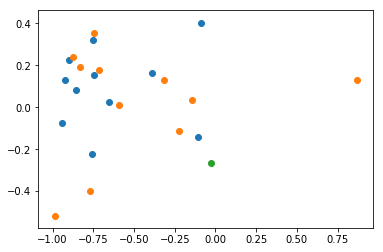

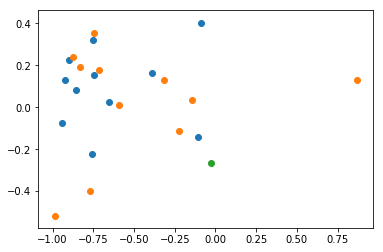

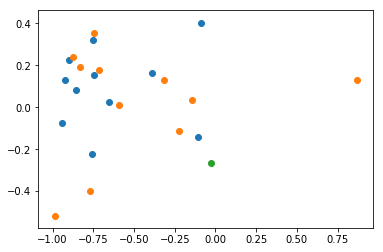

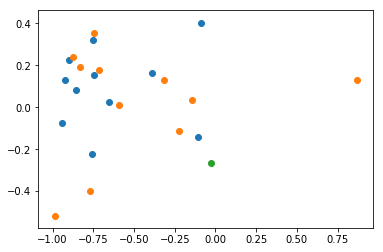

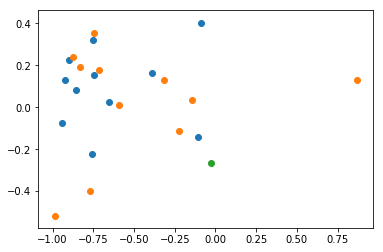

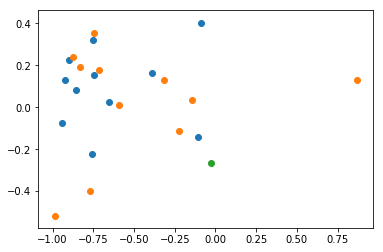

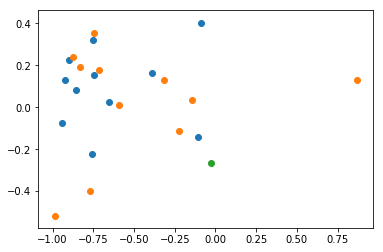

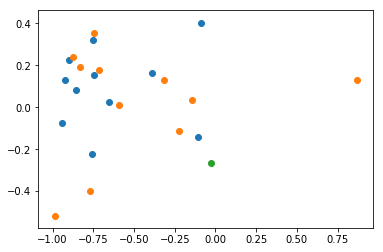

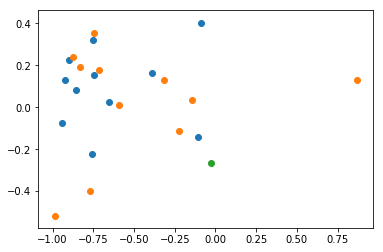

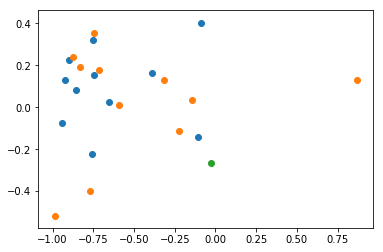

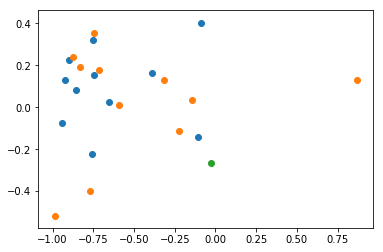

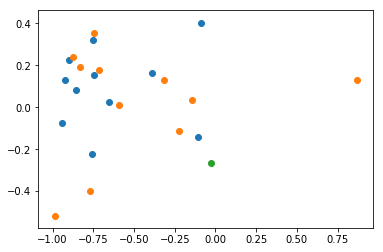

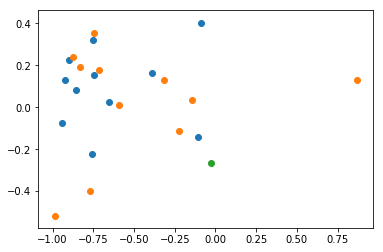

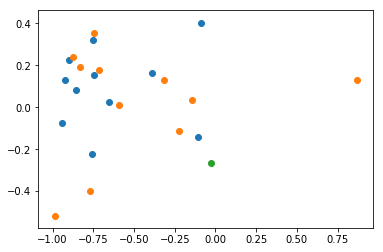

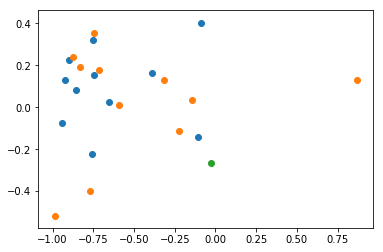

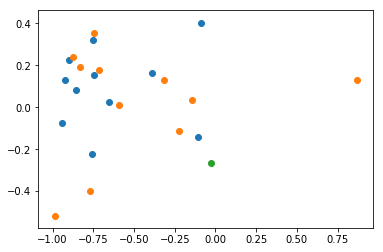

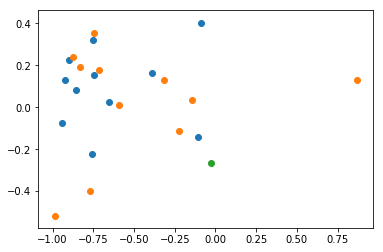

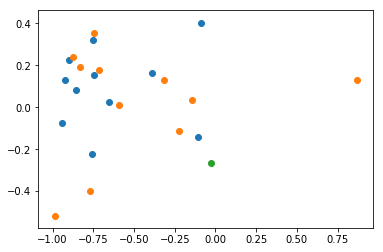

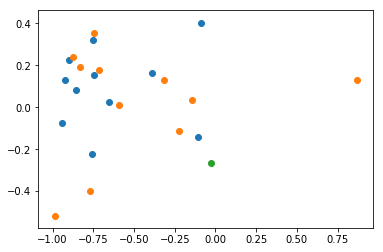

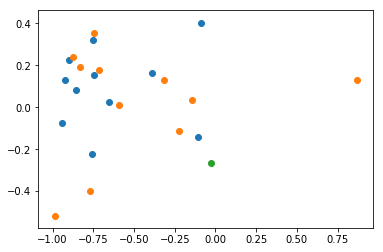

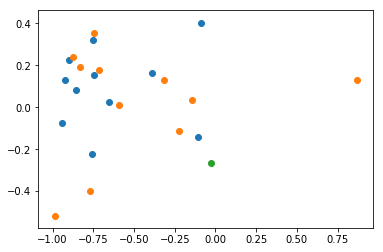

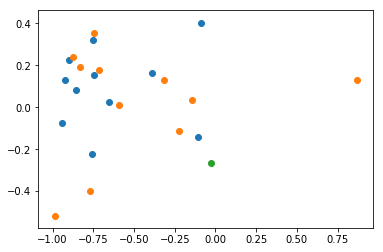

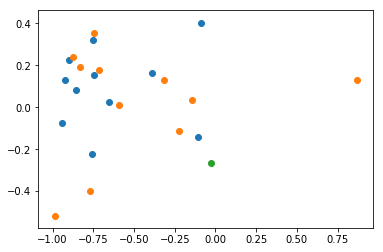

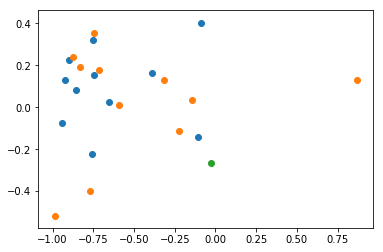

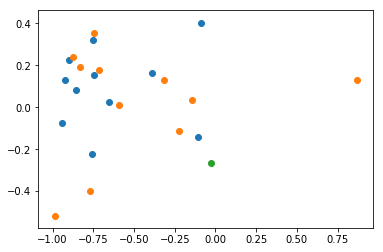

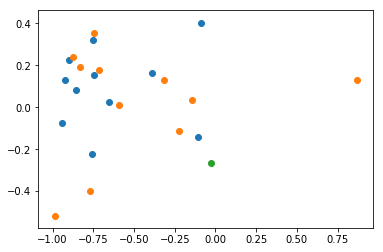

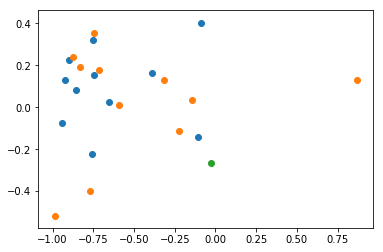

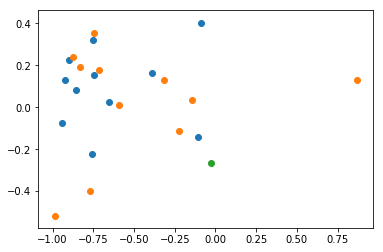

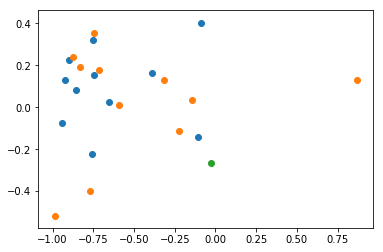

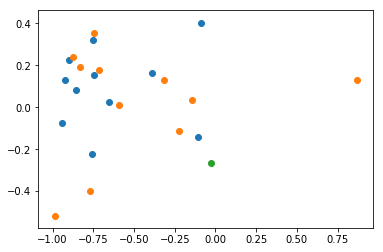

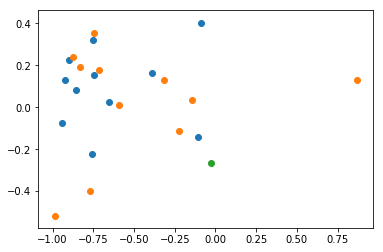

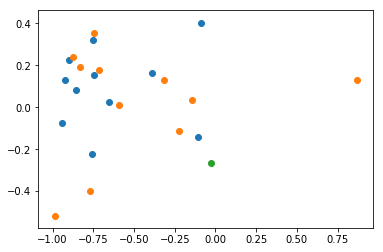

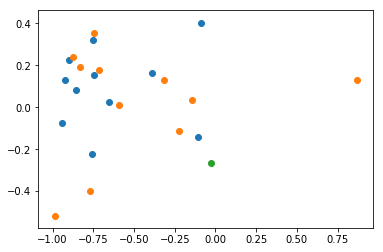

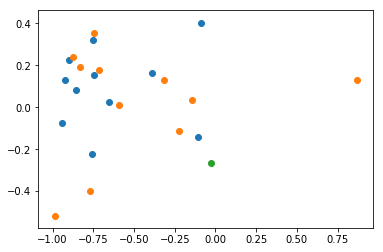

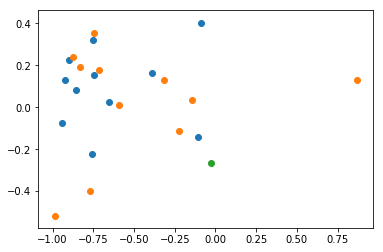

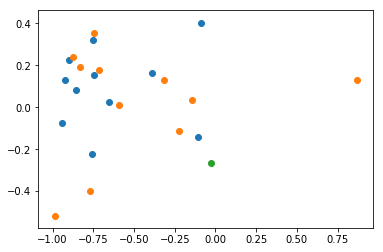

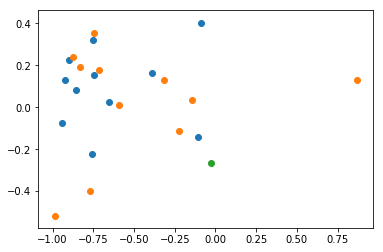

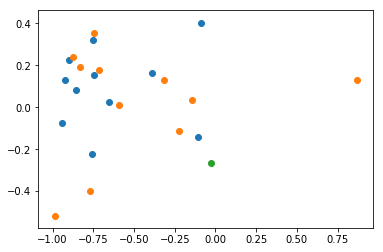

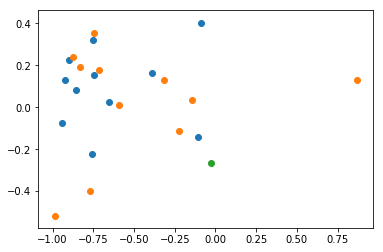

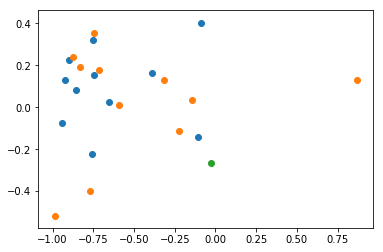

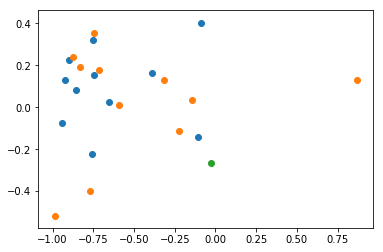

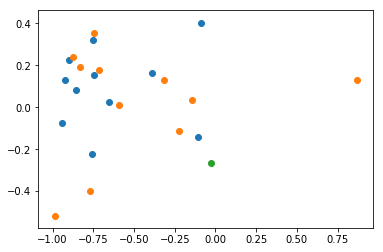

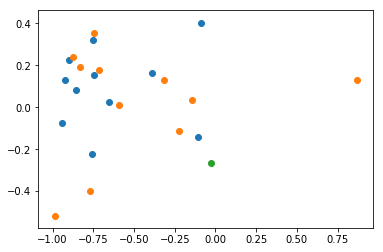

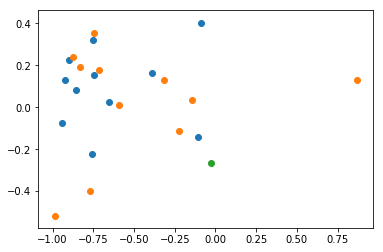

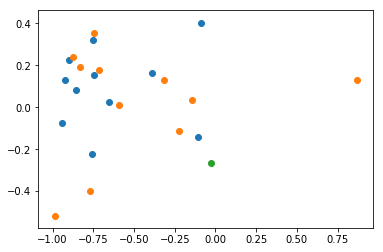

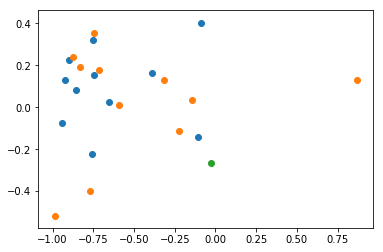

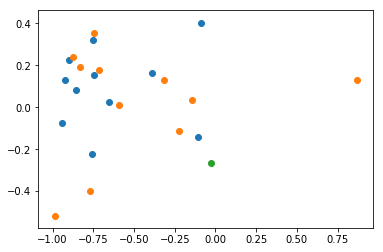

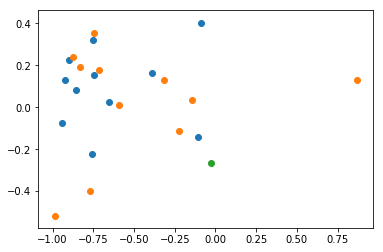

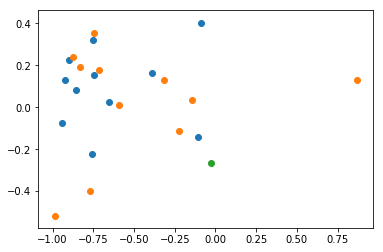

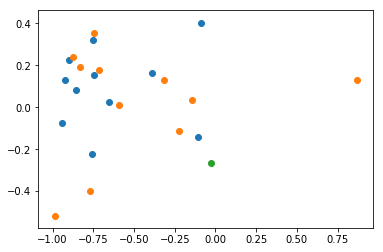

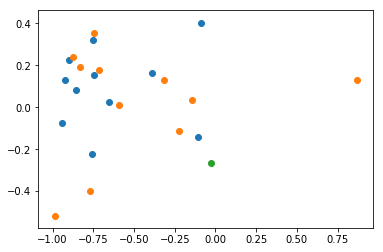

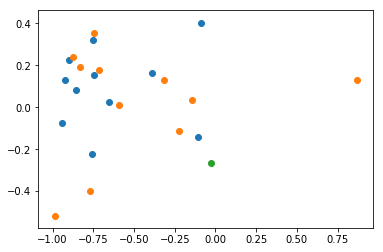

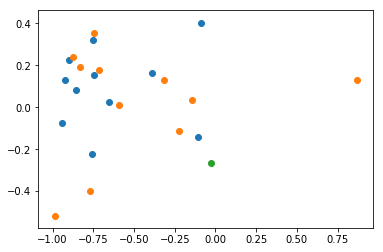

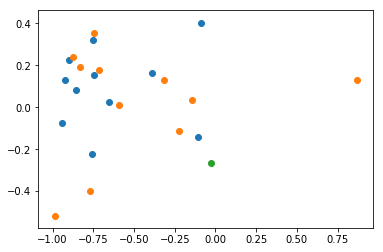

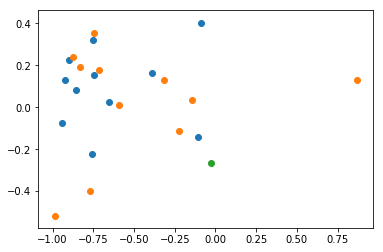

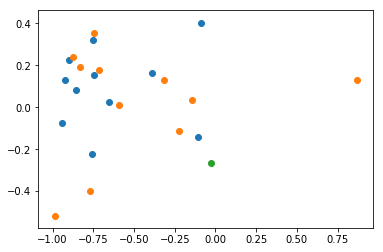

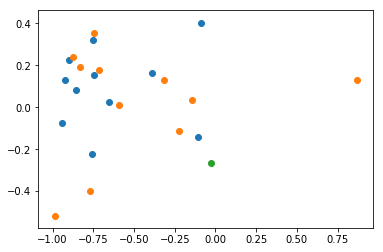

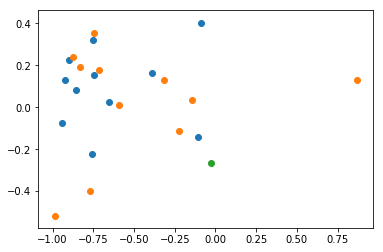

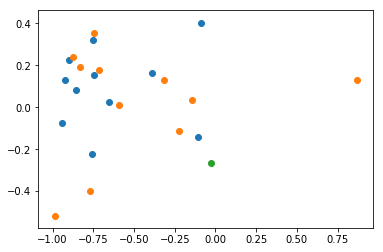

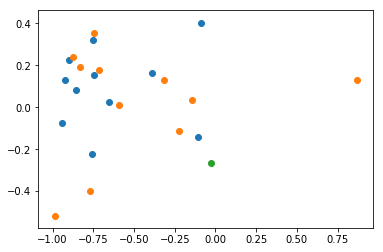

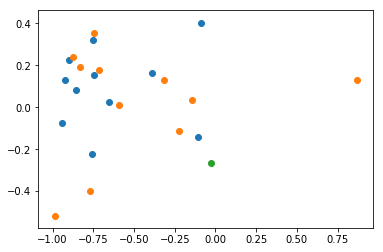

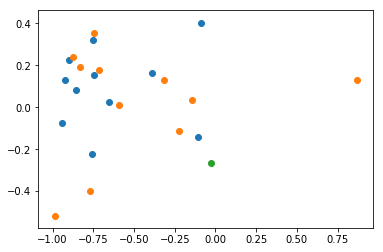

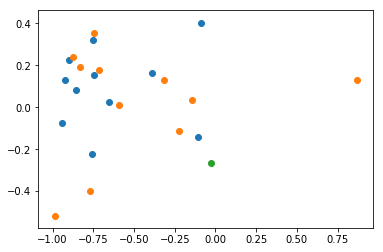

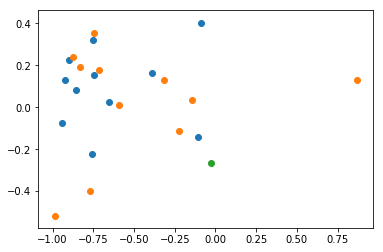

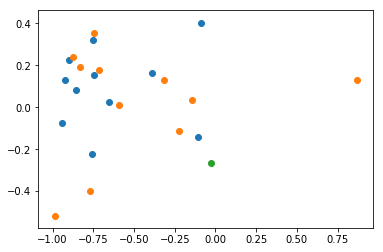

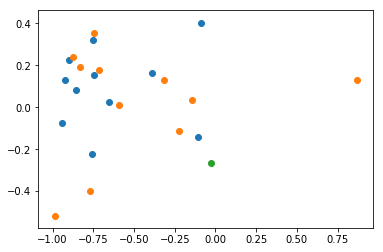

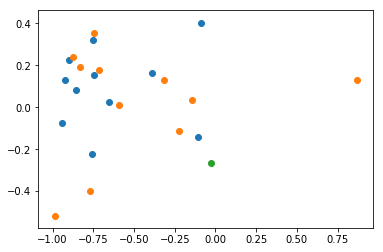

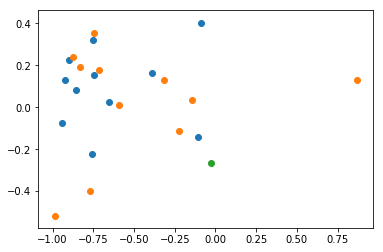

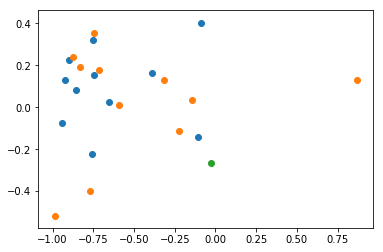

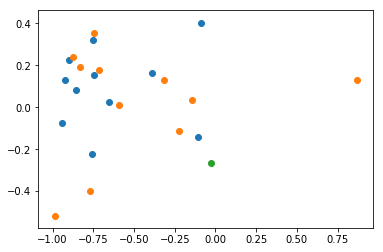

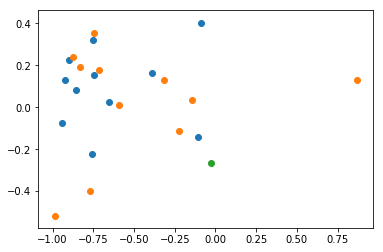

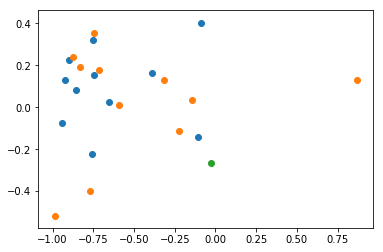

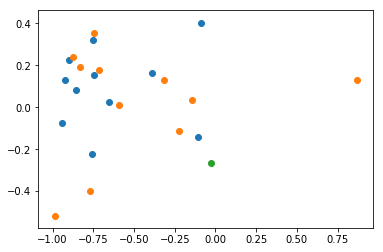

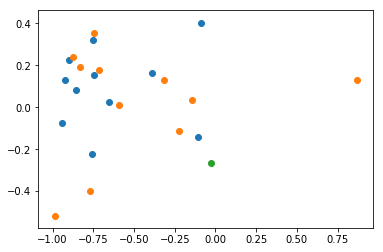

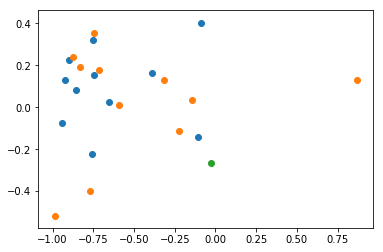

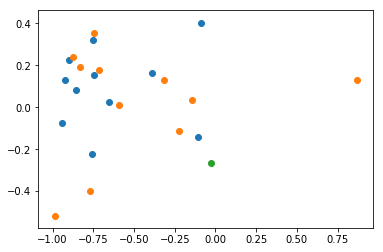

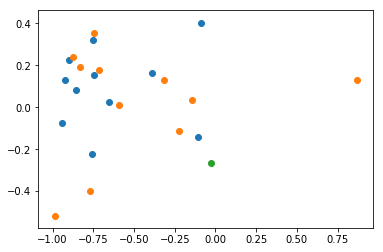

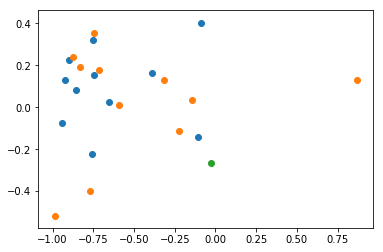

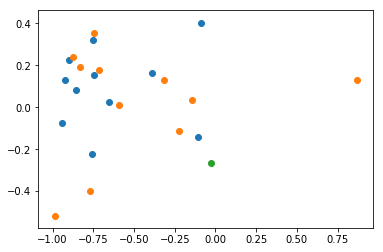

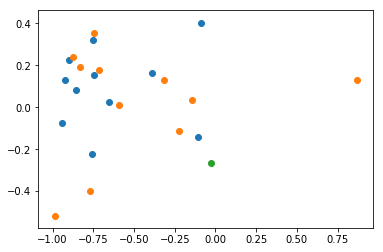

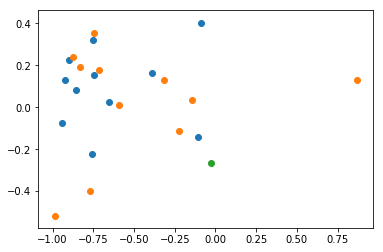

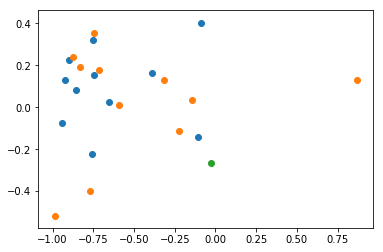

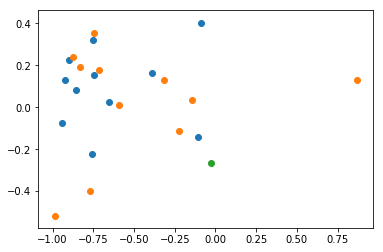

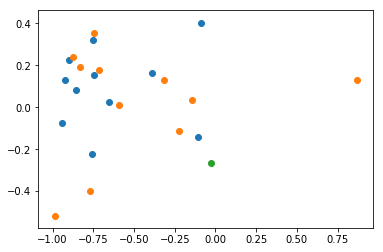

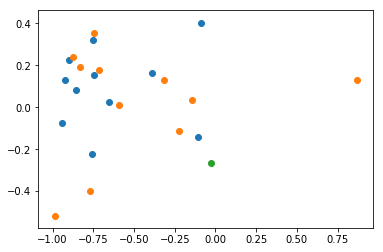

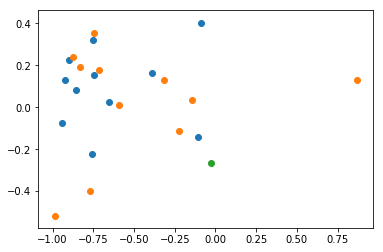

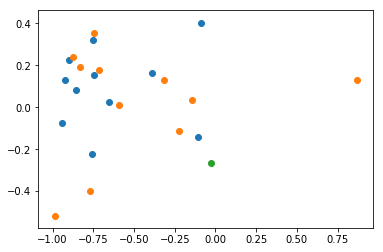

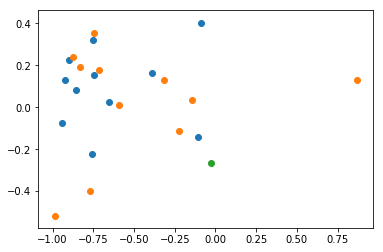

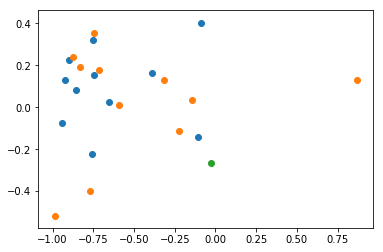

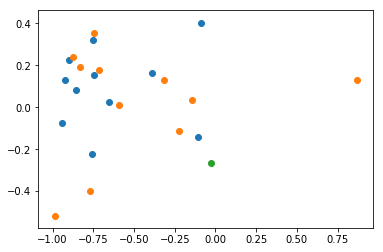

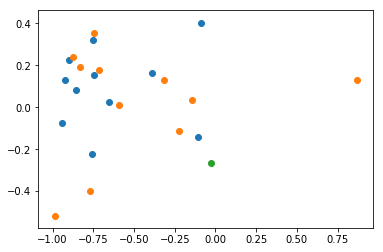

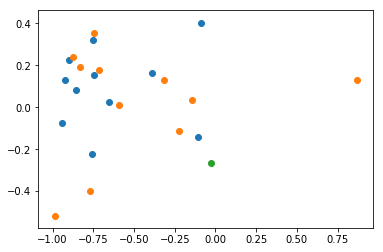

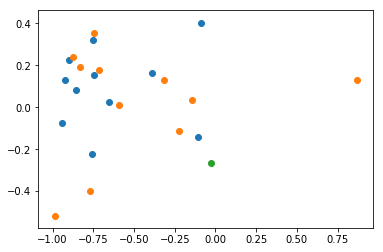

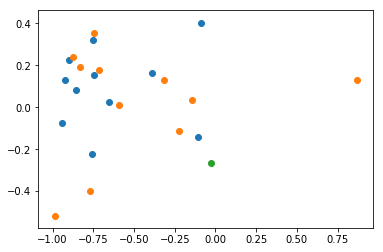

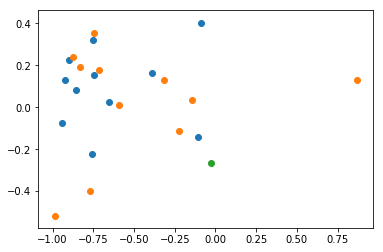

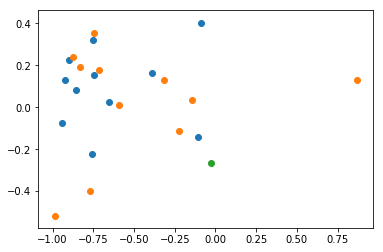

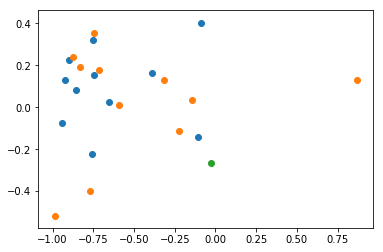

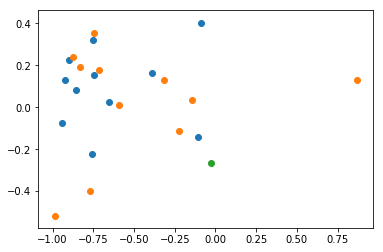

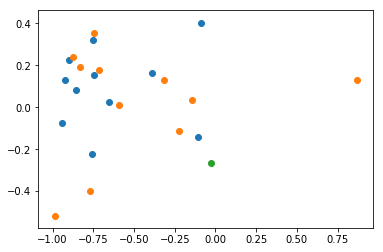

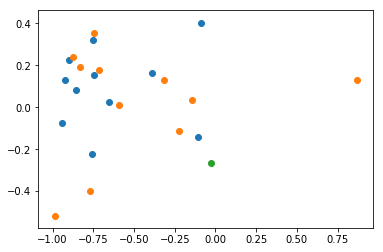

In [12]:
df = pd.read_csv("../Assets/Resources/Rostov.csv")
df["Time"] = df["Time"] - df["Time"][0]
df["Time"] = df["Time"].round(2)
df["X"] = df["X"]/525
df["Y"] = df["Y"]/525
for t in df["Time"].unique():
    d = df[df.Time==t]
    home = d[d.Side==1]
    away = d[d.Side==2]
    ball = d[d.Side==0]
    
    plt.scatter(home["X"], home["Y"])
    plt.scatter(away["X"], away["Y"])
    plt.scatter(ball["X"], ball["Y"])
    
    plt.show()

,Time,Side,Number,X,Y
0,27.42522,1,1,-0.817820,0.214631
1,27.42522,1,2,-0.744762,0.156190
2,27.42522,1,4,-0.752381,0.321905
3,27.42522,1,5,-0.921905,0.129524
4,27.42522,1,6,-0.899047,0.224762
5,27.42522,1,7,-0.944762,-0.076190
6,27.42522,1,9,-0.106667,-0.142857
7,27.42522,1,10,-0.386666,0.163810
8,27.42522,1,8,-0.857143,0.081905
9,27.42522,1,22,-0.653333,0.026667
